In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Embedding,BatchNormalization,Activation,Dropout,RNN,Conv1D,SimpleRNN,GRU,LSTM,InputLayer,RepeatVector
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 8

In [2]:
reber_grammer = [[("B",1)],
                [("T",2),("P",3)],
                [("S",2),("X",4)],
                [("T",3),("V",5)],
                [("X",3),("S",6)],
                [("P",4),("V",6)],
                [("E",None)]]
embed_reber_grammer = [[("B",1)],
                [("T",2),("P",3)],
                [(reber_grammer,4)],
                [(reber_grammer,5)],
                [("T",6)],
                [("P",6)],
                [("E",None)]]
def generate_embed_reber(reber_grammer=reber_grammer,embed_reber_grammer=embed_reber_grammer):
    out_put_string = ""
    letter = "B"
    place = 0
    second_place = 0
    letter_list = False
    while place is not None:
        if isinstance(letter,list):
            letter_list = True
        if letter_list:
            reb_res = reber_grammer[second_place][np.random.randint(0,len(reber_grammer[second_place]),1)[0]]
            letter = reb_res[0]
            second_place = reb_res[1]
            out_put_string = out_put_string+letter
            if second_place is None:
                letter_list = False
            continue
        emb_reb_res = embed_reber_grammer[place][np.random.randint(0,len(embed_reber_grammer[place]),1)[0]]
        letter = emb_reb_res[0]
        place = emb_reb_res[1]
        if isinstance(letter,list):
            continue
        out_put_string = out_put_string+letter
    return out_put_string
        

In [3]:
for i in range(25):
    print(generate_embed_reber())

BPBTSXSEPE
BPBPVPSEPE
BTBPTTVVETE
BPBTXXTVPXVPSEPE
BTBTSXSETE
BPBTSSSXSEPE
BPBPVPXVPXVPSEPE
BTBTSXXTVPXTVVETE
BPBPTTVPSEPE
BPBPVVEPE
BPBPTTVPSEPE
BTBTXSETE
BTBTSXXVVETE
BTBPTVPSETE
BPBPVPSEPE
BPBTXXTTVPSEPE
BTBTXXTTTVVETE
BPBTSSSXXVVEPE
BPBTXSEPE
BTBTSXXTTVPSETE
BTBTSSXXVVETE
BTBPTTVPSETE
BTBPTVVETE
BTBTXSETE
BTBTSSXSETE


In [4]:
good_to_bad = {
    "B": "TSXPVE",
    "E": "TSXPVB",
    "T": "SXE",
    "S": "TPVE",
    "X": "TPVE",
    "P": "SXE",
    "V": "SXVE"
}
def generate_not_embed_reber(reber_grammer=reber_grammer,embed_reber_grammer=embed_reber_grammer,
                            good_to_bad = good_to_bad):
    good_string = generate_embed_reber()
    switch_ind = np.random.randint(len(good_string))
    good_char = good_string[switch_ind]
    bad_chars = good_to_bad[good_char]
    bad_char = bad_chars[np.random.randint(len(bad_chars))]
    return good_string[:switch_ind] + bad_char + good_string[switch_ind+1:]

In [5]:
def generate_set(n_samp_class=1000):
    correct = [generate_embed_reber() for i in range(n_samp_class)]
    y = [1 for i in range(n_samp_class)] + [0 for i in range(n_samp_class)]
    bad = [generate_not_embed_reber() for i in range(n_samp_class)]
    return pd.DataFrame({"x":correct+bad,"y":y})
def preprocess(df,max_len = 10):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(["BTSXPVE"])
    x_texts = tokenizer.texts_to_sequences(df["x"])
    x_texts = pad_sequences(x_texts,padding='post',maxlen=max_len)
    return np.expand_dims(x_texts.astype(float),1), df["y"].to_numpy()

In [6]:
small_train = generate_set(10000)
small_val = generate_set(2000)
max_len = max([len(x) for x in small_train["x"]])
x_train,y_train = preprocess(small_train,max_len)
x_val,y_val = preprocess(small_val,max_len)

In [7]:
def plot_loss(history,max_y = 0,title = ""):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    if max_y != 0:
        plt.ylim((np.min(history.history['loss'])*0.75, max_y)) # scale control
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(title)
    plt.show()
    
def get_call_backs(model_name):
    chk_point = ModelCheckpoint(f'./best_model_{model_name}.h5',monitor = 'val_accuracy',mode = 'max',save_best_model = True,save_weights_only = True)
    early_stop = EarlyStopping(monitor="val_loss",patience=18,verbose=0,mode="min",restore_best_weights=True)
    reduce_le_plat = ReduceLROnPlateau(monitor="val_loss", factor = 0.5, patience = 5,verbose = 1)
    return [chk_point,early_stop,reduce_le_plat]

2022-09-12 05:58:30.279004: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-12 05:58:30.421054: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
625/625 [==============================] - 16s 13ms/step - loss: 0.6356 - accuracy: 0.5946 - val_loss: 0.5641 - val_accuracy: 0.6747
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5699 - accuracy: 0.6625 - val_loss: 0.5349 - val_accuracy: 0.6982
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5509 - accuracy: 0.6745 - val_loss: 0.5563 - val_accuracy: 0.6755
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5162 - accuracy: 0.6896 - val_loss: 0.6056 - val_accuracy: 0.6348
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5415 - accuracy: 0.6773 - val_loss: 0.5622 - val_accuracy: 0.6625
Epoch 6/20
625/625 [==============================] - 7s 12ms/step - loss: 0.5702 - accuracy: 0.6533 - val_loss: 0.4876 - val_accuracy: 0.7185
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5451 - accuracy: 0.6714 - val_loss: 0.4756 - val_accuracy: 0.719

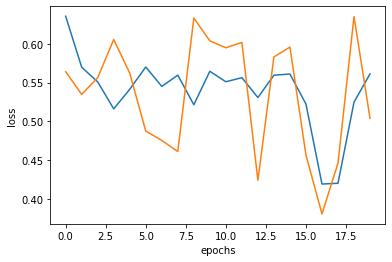

In [8]:
model = Sequential([
        #InputLayer(input_shape=[None]),
        #Embedding(8,5),
        LSTM(60,return_sequences=True,recurrent_dropout = 0.2),
        LSTM(50,return_sequences=True,recurrent_dropout = 0.17),
        LSTM(40,return_sequences=True,recurrent_dropout = 0.15),
        LSTM(30,return_sequences=True,recurrent_dropout = 0.12),
        LSTM(20,return_sequences=True,recurrent_dropout = 0.1),
        Dense(1,activation="sigmoid")])
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate = 5e-4), metrics=["accuracy"])
history = model.fit(x_train,y_train,batch_size = 32,validation_data = (x_val,y_val),
                    callbacks = get_call_backs("lstm8"), epochs=20)
plot_loss(history)

# 9

In [9]:
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
def generate_example(months=months):
    month = np.random.randint(12)
    day = np.random.randint(1,32)
    year = np.random.randint(1000,9999)
    format_1 = f"{months[month]} {0 if day <10 else ''}{day},{year}"
    format_2 = f"{year}-{0 if month <10 else ''}{month}-{0 if day <10 else ''}{day}"
    return format_1,format_2

def create_dataset(n_samp):
    data_set = [generate_example() for i in range(n_samp)]
    df = pd.DataFrame(data_set,columns =["x","y"])
    return df

def preprocess(df,max_len = 17,tokenizer = None):
    if isinstance(tokenizer,type(None)):
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(df['x'].to_list() + df['y'].to_list())
    x_texts = tokenizer.texts_to_sequences(df["x"])
    x_texts = pad_sequences(x_texts,padding='post',maxlen=max_len,value = 0)
    y_texts = tokenizer.texts_to_sequences(df["y"])
    y_texts = pad_sequences(y_texts,padding='post',maxlen=11,value = 0)
    return np.expand_dims(x_texts.astype(float),1), np.expand_dims(y_texts.astype(float),1), tokenizer

Epoch 1/100
313/313 [==============================] - 9s 15ms/step - loss: 1.7710 - accuracy: 0.3708 - val_loss: 1.4115 - val_accuracy: 0.4985
Epoch 2/100
313/313 [==============================] - 4s 13ms/step - loss: 1.2448 - accuracy: 0.5475 - val_loss: 1.1354 - val_accuracy: 0.5726
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 1.0820 - accuracy: 0.5823 - val_loss: 1.0505 - val_accuracy: 0.5868
Epoch 4/100
313/313 [==============================] - 4s 13ms/step - loss: 1.0093 - accuracy: 0.6040 - val_loss: 0.9816 - val_accuracy: 0.6139
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 0.9896 - accuracy: 0.6123 - val_loss: 0.9447 - val_accuracy: 0.6235
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 0.9213 - accuracy: 0.6384 - val_loss: 0.9099 - val_accuracy: 0.6397
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 0.8879 - accuracy: 0.6533 - val_loss: 0.8797 - val_accuracy:

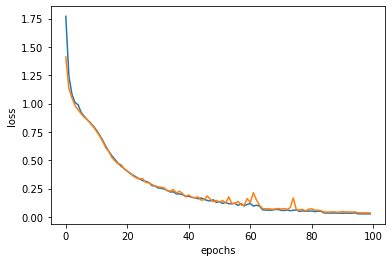

In [10]:
x_train,y_train,tokenizer = preprocess(create_dataset(10000),17)
x_valid,y_valid,tokenizer = preprocess(create_dataset(2000),17,tokenizer)

encoder = Sequential([
    LSTM(64),
])

decoder = Sequential([
    LSTM(64,return_sequences=True),
    Dense(12, activation="softmax")
])

model = Sequential([
    encoder,
    RepeatVector(11),
    decoder
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate = 1e-3), metrics=["accuracy"])
history = model.fit(x_train,y_train[:,0],batch_size = 32,validation_data = (x_valid,y_valid[:,0]),
                    callbacks = get_call_backs("ae9"), epochs=100)
plot_loss(history)